In [9]:
%load_ext autoreload
%autoreload 2

import sys, os
sys.path.insert(0, '../spikeinterface_dev/src/')

from pathlib import Path
import glob
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import spikeinterface.full as si
from metrics_predictor.metrics_predictor import MetricsPredictor

si.set_global_job_kwargs(n_jobs=-1, progress_bar=True, chunk_duration="1s")

print(si.__file__)
print(si.__version__)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
/disk/scratch/mhennig/spikeinterface/metrics-predictor/../spikeinterface_dev/src/spikeinterface/full.py
0.100.8


# Test recording

In [2]:
# where results will be stored
study_name = 'ground_truth_model'
study_folder = Path('./musall_lab_studies/')

recording_name = '2815_20230912_g0_imec0_preprocessed'
recording_dir = Path('/disk/data/musall_lab/Neuropixels/2815_20230912_g0_imec0_preprocessed/')
curated_sorting_folder = Path('/disk/data/musall_lab/bonn_data/neuronID/sorters_ouputs/2815_20230912/studies/2815_20230912_sortings/kilosort2_5')
sortings_folder = Path('musall_lab_sortings/2815_20230912_g0_imec0_preprocessed_sortings/')

MP = MetricsPredictor(study_name, study_folder=study_folder)

In [3]:
cached_recording_folder = study_folder / (recording_name+'_preprocessed')
if not cached_recording_folder.is_dir():
    print('filtering and saving preprocessed recording')
    RX = si.load_extractor(recording_dir)
    RX = si.highpass_filter(RX, freq_min=400.)
    RX = RX.save(folder=cached_recording_folder, format='binary')
else:
    RX = si.BinaryFolderRecording(cached_recording_folder)
    RX.annotate(is_filtered=True)

In [4]:
sortings = []
# only one sorting here, could add more
sorting = si.KiloSortSortingExtractor(curated_sorting_folder, remove_empty_units=False)
# have to fix sampling rate as KS stores it wrong
SX = si.NumpySorting(spikes=sorting.to_spike_vector(), sampling_frequency=RX.get_sampling_frequency(), unit_ids=sorting.get_unit_ids())
sortings.append(SX)

MP.add_sorting(SX, 'kilosort2_5_curated', RX=RX, recording_name=recording_name)

adding 421 units from kilosort2_5_curated to study


In [5]:
# read curator labels
all_sorting_units = SX.get_unit_ids()
curated_sets = []
for d in glob.glob(str(curated_sorting_folder / 'label*')):
    labels_file = glob.glob(str(d + '/*group*.tsv'))[0]
    print(labels_file)
    c1 = pd.read_csv(labels_file, sep='\t', index_col=0).reindex(all_sorting_units, fill_value='missing')
    labels_file = glob.glob(str(d + '/*label*.tsv'))[0]
    print(labels_file)
    c2 = pd.read_csv(labels_file, sep='\t', index_col=0).reindex(all_sorting_units, fill_value='missing')
    c1.loc[:,'group'] = c1.loc[:, 'group'].str.lower()
    c2.loc[:,'label'] = c2.loc[:, 'label'].str.lower()
    c2.loc[c2.label.isna()]='missing'
    c = pd.concat((c1,c2), verify_integrity=True, axis=1, copy=True,)
    curated_sets.append(c)
    
# set the curator labels for each unit
# (complicated curation scheme here)
# the relevant column in the table is gt_comp_curated_intersect
# this contains 'good' units on which both curators agree
recording = recording_name
sorting = 'kilosort2_5_curated'
for i,c in enumerate(curated_sets):
    MP.metrics_df[f'gt_comp_curator{i}'] = 0
    for unit in c.index:
        MP.metrics_df.loc[(MP.metrics_df.recording==recording) & (MP.metrics_df.sorter==sorting) &
                          (MP.metrics_df.sorter_unit_id==unit), 
                          f'gt_comp_curator_sua{i}'] = int((c.loc[unit]['group']=='good')|(c.loc[unit]['label']=='sua'))
        MP.metrics_df.loc[(MP.metrics_df.recording==recording) & (MP.metrics_df.sorter==sorting) &
                          (MP.metrics_df.sorter_unit_id==unit), 
                          f'gt_comp_curator{i}'] = int((c.loc[unit]['group']=='good')|(c.loc[unit]['label']=='psua')|(c.loc[unit]['label']=='sua'))
        MP.metrics_df.loc[(MP.metrics_df.recording==recording) & (MP.metrics_df.sorter==sorting) &
                          (MP.metrics_df.sorter_unit_id==unit), 
                          f'gt_comp_curator_mua{i}'] = int((c.loc[unit]['group']=='mua')|(c.loc[unit]['label']=='pmua')|(c.loc[unit]['label']=='mua'))
        MP.metrics_df.loc[(MP.metrics_df.recording==recording) & (MP.metrics_df.sorter==sorting) &
                          (MP.metrics_df.sorter_unit_id==unit), 
                          f'gt_comp_curator_noise{i}'] = int((c.loc[unit]['group']=='noise')|(c.loc[unit]['group']=='mua')|(c.loc[unit]['label']=='pmua')|(c.loc[unit]['label']=='mua')|(c.loc[unit]['label']=='psua'))
        
curs = [MP.metrics_df.loc[(MP.metrics_df.recording==recording) & (MP.metrics_df.sorter==sorting),f'gt_comp_curator{i}'] for i,c in enumerate(curated_sets)]
MP.metrics_df.loc[(MP.metrics_df.recording==recording) & (MP.metrics_df.sorter==sorting),'gt_comp_curated_intersect'] = (np.prod(curs, axis=0)>0).astype(int)
MP.metrics_df.loc[(MP.metrics_df.recording==recording) & (MP.metrics_df.sorter==sorting),'gt_comp_curated_sum'] = (np.sum(curs, axis=0)>0).astype(int)
curs = [MP.metrics_df.loc[(MP.metrics_df.recording==recording) & (MP.metrics_df.sorter==sorting),f'gt_comp_curator_noise{i}'] for i,c in enumerate(curated_sets)]
MP.metrics_df.loc[(MP.metrics_df.recording==recording) & (MP.metrics_df.sorter==sorting),'gt_comp_curated_noise_intersect'] = (np.prod(curs, axis=0)>0).astype(int)

/disk/data/musall_lab/bonn_data/neuronID/sorters_ouputs/2815_20230912/studies/2815_20230912_sortings/kilosort2_5/labels_SAR/cluster_group_SAR.tsv
/disk/data/musall_lab/bonn_data/neuronID/sorters_ouputs/2815_20230912/studies/2815_20230912_sortings/kilosort2_5/labels_SAR/cluster_label_SAR.tsv
/disk/data/musall_lab/bonn_data/neuronID/sorters_ouputs/2815_20230912/studies/2815_20230912_sortings/kilosort2_5/labels_AJ/cluster_group_AJ.tsv
/disk/data/musall_lab/bonn_data/neuronID/sorters_ouputs/2815_20230912/studies/2815_20230912_sortings/kilosort2_5/labels_AJ/cluster_label_AJ.tsv


# Metrics

In [6]:
metrics = si.get_quality_metric_list()+si.get_quality_pca_metric_list()
# ot these as too slow to compute
metrics.remove('nn_noise_overlap')
metrics.remove('nn_isolation')

MP.compute_metrics(reco mpute=False, 
                   max_spikes_per_unit=100, 
                   overwrite_sorting_analyzer=False, 
                   metric_list=metrics, 
                   n_jobs = -1,
                   n_pca_components = 2,
                   verbose=True,
                   remove_outliers=False
                  )


loading cached metrics for 2815_20230912_g0_imec0_preprocessed/kilosort2_5_curated from musall_lab_studies/ground_truth_model/metrics_2815_20230912_g0_imec0_preprocessed_kilosort2_5_curated.csv
dropping metrics without valid values: 


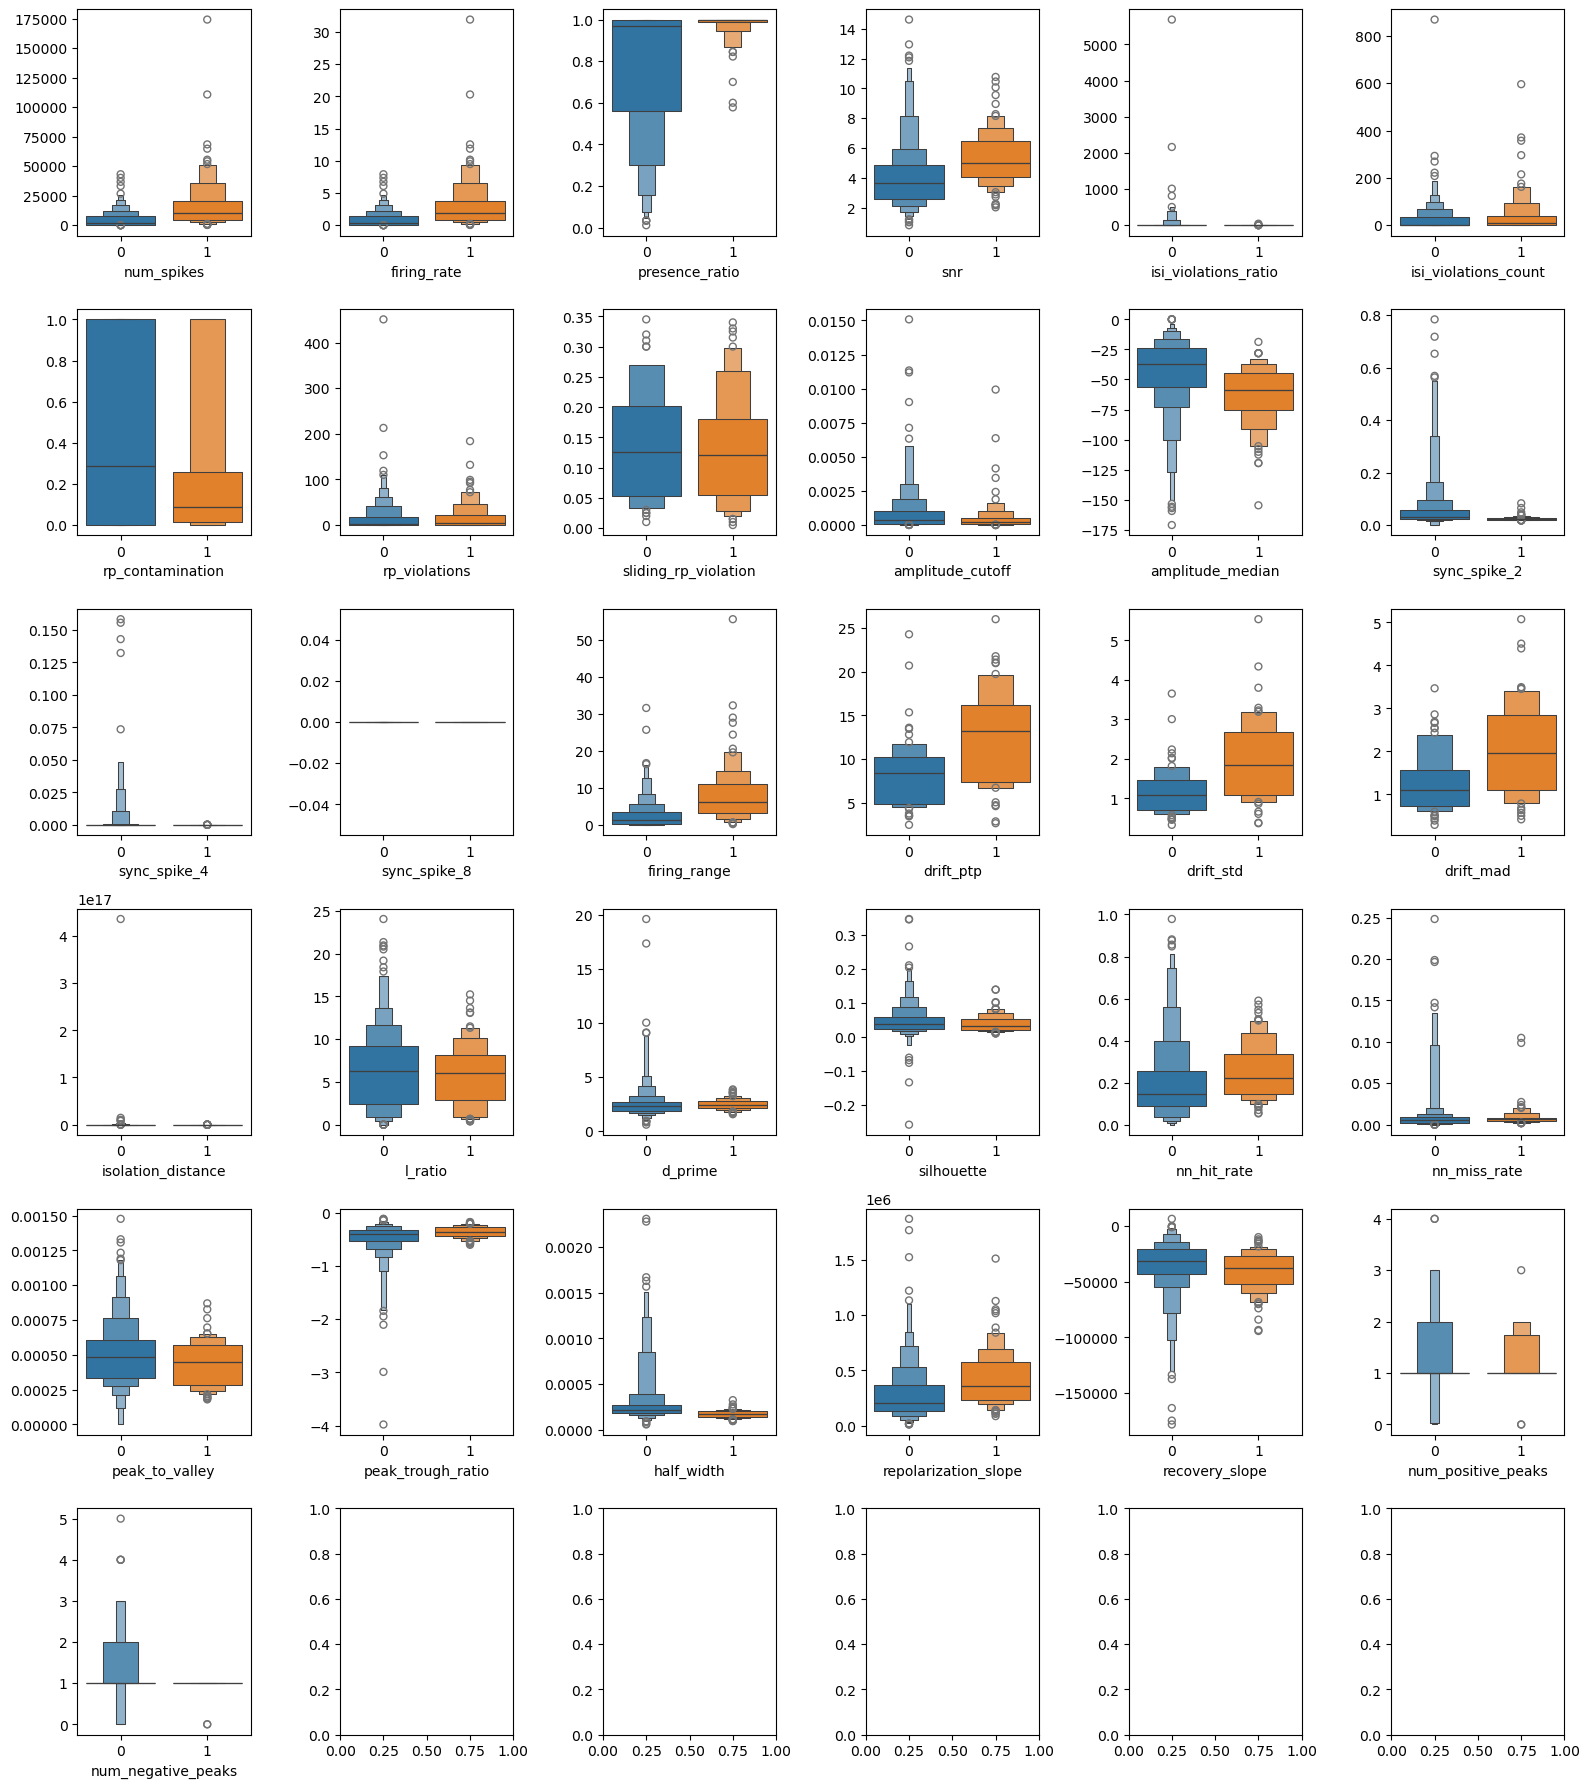

In [15]:
# merics stats
plot_recording = recording_name
target_col = 'gt_comp_curated_intersect'

plot_df = MP.metrics_df[MP.metrics_df.recording==plot_recording].copy()
_,ax = plt.subplots(len(metrics)//6+1,6, figsize=(16,(len(metrics)//6+1)*3))
ax = ax.flatten()
plot_data = []
metrics, _, _, _ = MP.get_study_info()
for i,m in enumerate(metrics):
    data = plot_df[m]
    d_orig = data.values.astype(float)
    plot_data.append(d)
    inds = plot_df[target_col]==1
    sns.boxenplot([data[~inds].values , data[inds].values], ax=ax[i])
    ax[i].set_xlabel(m)
plt.tight_layout()



# Model

In [16]:
# fit models n_splits times
def fit_test_model(MP, recording_train, recording_test, key1, key2, train_sorters = None, test_sorters = None, metrics = None, n_splits = 1, verbose=True, train_size=.8, standard_scale=True, log_transform=True, oversample=False, solver="lbfgs"):
    if metrics==None:
        metrics, _, _, _ = MP.get_study_info()
    fit_metrics = []
    fit_coefs = []
    for i in range(n_splits):
        if recording_train is recording_test:
            MP.create_train_test_split(recording_names=recording_train, sorter_names=train_sorters, random_state=i, verbose=verbose, test_size=1-train_size, log_transform=log_transform, standard_scale=standard_scale)
        else:
            MP.create_train_set(recording_names=[recording_train,], sorter_names=train_sorters, verbose=verbose, train_size=train_size, random_state=i)
            MP.create_test_set(recording_names=[recording_test,], log_transform=log_transform, standard_scale=standard_scale, verbose=verbose)
        MP.fit(metrics, key1, solver=solver, penalty='l2', C=1, oversample=oversample)
        y_pred = MP.predict()
        fit_metrics.append(MP.get_model_metrics(y_pred, recording=recording_test, sorter=test_sorters, target_feature=key2, print_stats=False))
        fit_coefs.append(MP.model.coef_[0])
    fit_metrics = np.array(fit_metrics)
    return fit_metrics, fit_coefs


In [17]:
MP.print_study_info()

study name: ground_truth_model
study folder: musall_lab_studies/ground_truth_model
number of sorters: 1
Study summary:
--------------
metrics: num_spikes, firing_rate, presence_ratio, snr, isi_violations_ratio, isi_violations_count, rp_contamination, rp_violations, sliding_rp_violation, amplitude_cutoff, amplitude_median, sync_spike_2, sync_spike_4, sync_spike_8, firing_range, drift_ptp, drift_std, drift_mad, isolation_distance, l_ratio, d_prime, silhouette, nn_hit_rate, nn_miss_rate, peak_to_valley, peak_trough_ratio, half_width, repolarization_slope, recovery_slope, num_positive_peaks, num_negative_peaks
unit info: sorter, recording, sorter_unit_id
agreement targets:
ground truth targets: 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1
number of units: 421
Class imbalance of targets:
----------------
                                    gt_comp_curator0 gt_comp_curator_sua0 gt_comp_curator_mua0 gt_comp_curator_noise0 gt_comp_curator1 gt_comp_curator_sua1 gt_comp_curator_mua1 gt_comp_curator_noise1 gt

In [58]:
metrics, _, _, _ = MP.get_study_info()
metrics.remove('sync_spike_8') # this is strange
m, c = fit_test_model(MP, recording_name, recording_name, 'gt_comp_curated_intersect', 'gt_comp_curated_intersect', 
                   train_sorters = None, test_sorters = None, metrics = metrics, n_splits = 20, 
                   verbose=False, standard_scale=True, log_transform=False, train_size=.8, oversample=True)

In [59]:
for k in ['f1','precision','recall','balanced_accuracy','true_positives', 'false_positives', 'false_negatives', 'true_negatives']:
    print(f'{k}: {np.mean([v[k] for v in m]):.2f} +/- {np.std([v[k] for v in m]):.2f}')
    

f1: 0.70 +/- 0.07
precision: 0.65 +/- 0.10
recall: 0.77 +/- 0.09
balanced_accuracy: 0.64 +/- 0.09
true_positives: 15.50 +/- 2.56
false_positives: 8.75 +/- 3.25
false_negatives: 4.65 +/- 2.01
true_negatives: 56.10 +/- 3.60


Text(0.5, 1.0, 'Abs regression cofficients for metrics')

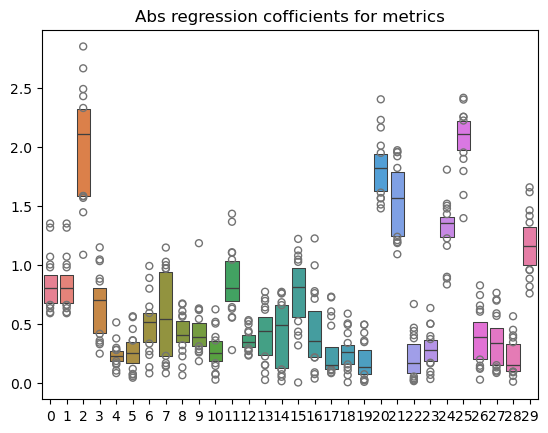

In [60]:
sns.boxenplot(np.abs(np.array(c)))
plt.title('Abs regression cofficients for metrics')
